In [1]:
import numpy as np
import pandas as pd
from astropy.table import Table, Column
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from astropy.io import fits
from scipy.interpolate import interp1d
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams["font.family"] = "serif"
plt.rcParams['text.usetex'] = False
#%matplotlib inline

In [2]:
# COSMOS2015 photometry catalog from Laigle et al. 2016 (ftp://ftp.iap.fr/pub/from_users/hjmcc/COSMOS2015/)
# It will become important later because we are tying to build a legacy reference sample 
COSMOS2015 = fits.open('COSMOS2015_Laigle+_v2.1.fits')

In [3]:
# Make the basic cuts for sample1
mask_basic = (COSMOS2015[1].data['MASS_MED'] > 7.5) & (COSMOS2015[1].data['MASS_MED'] < 11)

mask_basic *= COSMOS2015[1].data['TYPE'] == 0
mask_basic *= COSMOS2015[1].data['FLAG_HJMCC'] == 0
mask_basic *= COSMOS2015[1].data['FLAG_PETER'] == 0
mask_basic *= COSMOS2015[1].data['FLAG_COSMOS'] == 1

mask_sample1 = mask_basic * (COSMOS2015[1].data['redshift'] > 0.0001) & (COSMOS2015[1].data['redshift'] < 0.20)
sample1 = COSMOS2015[1].data[mask_sample1]

# Where does the good_z field come from? 
# Spec_z catalog from /Users/alexie/Work/PhotozLaigle/OBSERVED_TARGETS_15April2015_withHeader.dat 
# good_z = Quality flag 3 <= Q_f <= 5 and 0 < z_spec < 9

mask_goodz = mask_sample1 * COSMOS2015[1].data['good_z']
sample_goodz = COSMOS2015[1].data[mask_goodz]

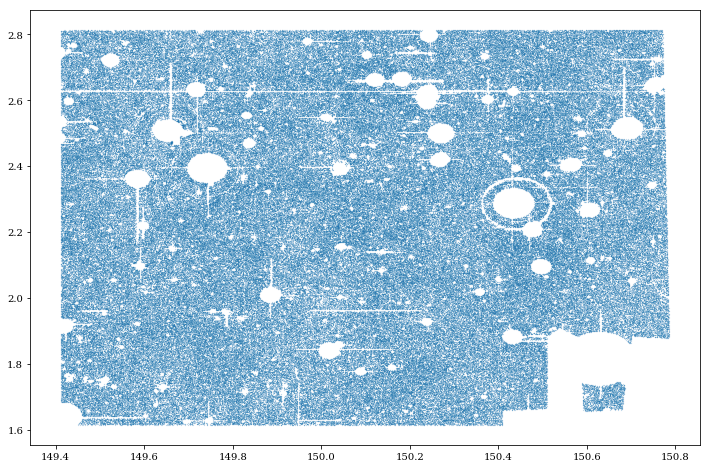

In [4]:
plt.scatter(COSMOS2015[1].data[mask_basic]['ALPHA_J2000'],COSMOS2015[1].data[mask_basic]['DELTA_J2000'],s=0.01)
plt.show()

In [5]:
COSMOS_area_estimate = (150.75-149.4)*(2.8-1.6)-(150.78-150.5)*(1.9-1.6)
DEIMOS_FOV = 16 * 4 / 3600
print(COSMOS_area_estimate)

1.5359999999999925


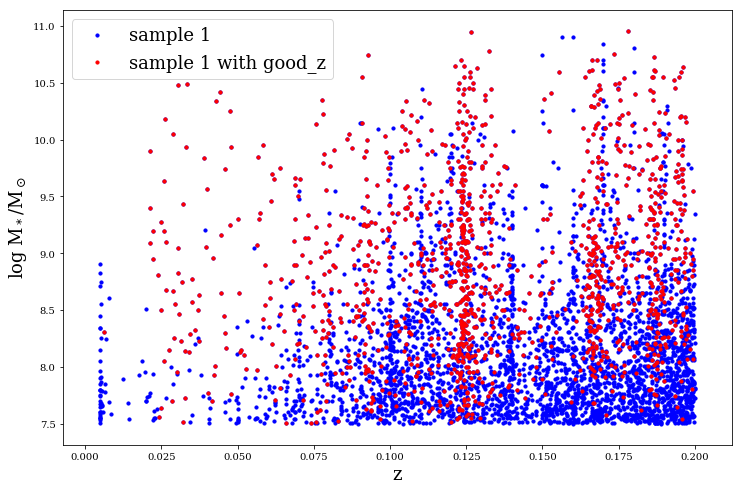

In [6]:
plt.scatter(sample1['redshift'],sample1['MASS_MED'],s=10,c='b',label='sample 1')
plt.scatter(sample_goodz['redshift'],sample_goodz['MASS_MED'],s=10,c='r',label='sample 1 with good_z')
plt.xlabel('z',fontsize=18)
plt.ylabel('log M$_*$/M$_\odot$',fontsize=18)
plt.legend(fontsize=18)
plt.show()

In [7]:
# Priority = 500 (lower)
# Here we only want to target things that $don't$ already have a specz
# *** Make a cut here on things that have a good specz already

mask_sample1_bin1 = mask_sample1 * (COSMOS2015[1].data['MASS_MED'] > 7.5) & (COSMOS2015[1].data['MASS_MED'] < 7.75) & (COSMOS2015[1].data['good_z'] == 0)
mask_sample1_bin2 = mask_sample1 * (COSMOS2015[1].data['MASS_MED'] > 7.75) & (COSMOS2015[1].data['MASS_MED'] < 8.0) & (COSMOS2015[1].data['good_z'] == 0)

# Priority = 999 (high priority)
# Here we want to target $everything$, regardless of wheter or not a specz already exists.
# This is because we want to get Halpha sigma values

mask_sample1_bin3 = mask_sample1 * (COSMOS2015[1].data['MASS_MED'] > 8.0) & (COSMOS2015[1].data['MASS_MED'] < 8.25)
mask_sample1_bin4 = mask_sample1 * (COSMOS2015[1].data['MASS_MED'] > 8.25) & (COSMOS2015[1].data['MASS_MED'] < 8.5)
mask_sample1_bin5 = mask_sample1 * (COSMOS2015[1].data['MASS_MED'] > 8.5) & (COSMOS2015[1].data['MASS_MED'] < 8.75)
mask_sample1_bin6 = mask_sample1 * (COSMOS2015[1].data['MASS_MED'] > 8.75) & (COSMOS2015[1].data['MASS_MED'] < 9.0)

#priority = 500 (lower)
# *** Make a cut here on things that have a good specz already
mask_sample1_bin7 = mask_sample1 * (COSMOS2015[1].data['MASS_MED'] > 9.0) & (COSMOS2015[1].data['MASS_MED'] < 9.5) & (COSMOS2015[1].data['good_z'] == 0)
mask_sample1_bin8 = mask_sample1 * (COSMOS2015[1].data['MASS_MED'] > 9.5) & (COSMOS2015[1].data['MASS_MED'] < 10.0) & (COSMOS2015[1].data['good_z'] == 0)
mask_sample1_bin9 = mask_sample1 * (COSMOS2015[1].data['MASS_MED'] > 10.0) & (COSMOS2015[1].data['MASS_MED'] < 10.5) & (COSMOS2015[1].data['good_z'] == 0)
mask_sample1_bin10 = mask_sample1 * (COSMOS2015[1].data['MASS_MED'] > 10.5) & (COSMOS2015[1].data['MASS_MED'] < 11.0) & (COSMOS2015[1].data['good_z'] == 0)

sample1_bin1 = COSMOS2015[1].data[mask_sample1_bin1]
sample1_bin2 = COSMOS2015[1].data[mask_sample1_bin2]
sample1_bin3 = COSMOS2015[1].data[mask_sample1_bin3]
sample1_bin4 = COSMOS2015[1].data[mask_sample1_bin4]
sample1_bin5 = COSMOS2015[1].data[mask_sample1_bin5]
sample1_bin6 = COSMOS2015[1].data[mask_sample1_bin6]
sample1_bin7 = COSMOS2015[1].data[mask_sample1_bin7]
sample1_bin8 = COSMOS2015[1].data[mask_sample1_bin8]
sample1_bin9 = COSMOS2015[1].data[mask_sample1_bin9]
sample1_bin10 = COSMOS2015[1].data[mask_sample1_bin10]

In [8]:
number_bin1 = len(sample1_bin1) / COSMOS_area_estimate * DEIMOS_FOV
number_bin2 = len(sample1_bin2) / COSMOS_area_estimate * DEIMOS_FOV
number_bin3 = len(sample1_bin3) / COSMOS_area_estimate * DEIMOS_FOV
number_bin4 = len(sample1_bin4) / COSMOS_area_estimate * DEIMOS_FOV
number_bin5 = len(sample1_bin5) / COSMOS_area_estimate * DEIMOS_FOV
number_bin6 = len(sample1_bin6) / COSMOS_area_estimate * DEIMOS_FOV
number_bin7 = len(sample1_bin7) / COSMOS_area_estimate * DEIMOS_FOV
number_bin8 = len(sample1_bin8) / COSMOS_area_estimate * DEIMOS_FOV
number_bin9 = len(sample1_bin9) / COSMOS_area_estimate * DEIMOS_FOV
number_bin10 = len(sample1_bin10) / COSMOS_area_estimate * DEIMOS_FOV
total_per_mask = number_bin1 + number_bin2 + number_bin3 + number_bin4 + number_bin5
+ number_bin6 + number_bin7 + number_bin8 + number_bin9 + number_bin10

# ***** print here the bin numbers, mass range, and priortity number, and average number per DEIMOS FOV
print('bin1,',' 7.50 < logM < 7.75,', 'priortity number = 500,', 'galaxies per DEIMOS mask =',number_bin1)
print('bin2,',' 7.75 < logM < 8.00,', 'priortity number = 500,', 'galaxies per DEIMOS mask =',number_bin2)
print('bin3,',' 8.00 < logM < 8.25,', 'priortity number = 999,', 'galaxies per DEIMOS mask =',number_bin3)
print('bin4,',' 8.25 < logM < 8.50,', 'priortity number = 999,', 'galaxies per DEIMOS mask =',number_bin4)
print('bin5,',' 8.50 < logM < 8.75,', 'priortity number = 999,', 'galaxies per DEIMOS mask =',number_bin5)
print('bin6,',' 8.75 < logM < 9.00,', 'priortity number = 999,', 'galaxies per DEIMOS mask =',number_bin6)
print('bin7,',' 9.00 < logM < 9.50,', 'priortity number = 500,', 'galaxies per DEIMOS mask =',number_bin7)
print('bin8,',' 9.50 < logM < 10.0,', 'priortity number = 500,', 'galaxies per DEIMOS mask =',number_bin8)
print('bin9,',' 10.0 < logM < 10.5,', 'priortity number = 500,', 'galaxies per DEIMOS mask =',number_bin9)
print('bin10,','10.5 < logM < 11.0,', 'priortity number = 500,', 'galaxies per DEIMOS mask =',number_bin10)
print()
print('total galaxies per DEIMOS mask =',total_per_mask)

bin1,  7.50 < logM < 7.75, priortity number = 500, galaxies per DEIMOS mask = 11.597222222222278
bin2,  7.75 < logM < 8.00, priortity number = 500, galaxies per DEIMOS mask = 8.032407407407447
bin3,  8.00 < logM < 8.25, priortity number = 999, galaxies per DEIMOS mask = 7.384259259259295
bin4,  8.25 < logM < 8.50, priortity number = 999, galaxies per DEIMOS mask = 5.949074074074103
bin5,  8.50 < logM < 8.75, priortity number = 999, galaxies per DEIMOS mask = 4.386574074074096
bin6,  8.75 < logM < 9.00, priortity number = 999, galaxies per DEIMOS mask = 3.425925925925943
bin7,  9.00 < logM < 9.50, priortity number = 500, galaxies per DEIMOS mask = 1.7592592592592677
bin8,  9.50 < logM < 10.0, priortity number = 500, galaxies per DEIMOS mask = 0.8101851851851892
bin9,  10.0 < logM < 10.5, priortity number = 500, galaxies per DEIMOS mask = 0.38194444444444636
bin10, 10.5 < logM < 11.0, priortity number = 500, galaxies per DEIMOS mask = 0.10416666666666717

total galaxies per DEIMOS mask =